# Zarr example
The following example will use xarray to store data locally and remotely in the zarr format.

## Software used
- [xarray](http://xarray.pydata.org/en/stable/index.html)
- [zarr](https://zarr.readthedocs.io/en/stable/index.html)
- [s3fs](https://github.com/dask/s3fs)

## Environment
Below is the command to create the conda environment to use. This uses the [mamba](https://github.com/mamba-org/mamba), a reimplementation of conda in c++. You can replace `mamba` with `conda` and achieve the same result.

```shell
mamba create -n zarr -c conda-forge python=3.8.8 xarray zarr s3fs netcdf4 dask distributed matplotlib ipykernel
```

In [1]:
import os
import random
import string
import s3fs
import xarray as xr
import zarr

The dataset below is around 122 GB.

In [2]:
uid = "".join([random.choice(string.ascii_letters) for _ in range(8)])

identifier = f"tas_3hr_HadGEM3-GC31-MM_historical_r1i1p1f3_gn_{uid}"

path = "/CMIP6/CMIP/MOHC/HadGEM3-GC31-MM/historical/r1i1p1f3/3hr/tas/gn/v20200720"

# Open and subset data

We'll open the multi file dataset and take a subset of the first 1,000 time steps

In [3]:
ds = xr.open_mfdataset(f"{path}/*.nc", chunks={"time": 100})
ds

<xarray.Dataset>
Dimensions:   (bnds: 2, lat: 324, lon: 432, time: 475200)
Coordinates:
  * time      (time) object 1850-01-01 03:00:00 ... 2015-01-01 00:00:00
  * lat       (lat) float64 -89.72 -89.17 -88.61 -88.06 ... 88.61 89.17 89.72
  * lon       (lon) float64 0.4167 1.25 2.083 2.917 ... 357.1 357.9 358.7 359.6
    height    float64 1.5
Dimensions without coordinates: bnds
Data variables:
    lat_bnds  (time, lat, bnds) float64 dask.array<chunksize=(2880, 324, 2), meta=np.ndarray>
    lon_bnds  (time, lon, bnds) float64 dask.array<chunksize=(2880, 432, 2), meta=np.ndarray>
    tas       (time, lat, lon) float32 dask.array<chunksize=(100, 324, 432), meta=np.ndarray>
Attributes: (12/47)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  0.0
    creation_date:          2020-07-15T13:37:54Z
    ...                     ...
    tracking_id:            hdl:21.14100/0679cd5d-7f68-475d-b6d0-c94b62505062
    variable_id:            tas
    variable_name:          tas
    variant_label:          r1i1p1f3
    license:                CMIP6 model data produced by the Met Office Hadle...
    cmor_version:           3.4.0

In [4]:
subset = ds.isel({"time": slice(0, 1000)})

print(subset.nbytes/1e9, "GB")

0.571982056 GB


# Local Zarr store
In the first example we'll create a local zarr store using [`DirectoryStore`](https://zarr.readthedocs.io/en/stable/api/storage.html#zarr.storage.DirectoryStore).

In [5]:
local_path = "/home/jovyan/zarr_test"

if not os.path.exists(local_path):
    os.makedirs(local_path) 

store = zarr.DirectoryStore(local_path)

subset.to_zarr(store, group=identifier, consolidated=True)

Lets list out the store and see how zarr stores chunks.

In [6]:
list(store)

['.zmetadata',
 '.zgroup',
 'tas_3hr_HadGEM3-GC31-MM_historical_r1i1p1f3_gn_rcbdswYd/.zattrs',
 'tas_3hr_HadGEM3-GC31-MM_historical_r1i1p1f3_gn_rcbdswYd/.zgroup',
 'tas_3hr_HadGEM3-GC31-MM_historical_r1i1p1f3_gn_rcbdswYd/lon/.zattrs',
 'tas_3hr_HadGEM3-GC31-MM_historical_r1i1p1f3_gn_rcbdswYd/lon/.zarray',
 'tas_3hr_HadGEM3-GC31-MM_historical_r1i1p1f3_gn_rcbdswYd/lon/0',
 'tas_3hr_HadGEM3-GC31-MM_historical_r1i1p1f3_gn_rcbdswYd/lat_bnds/.zattrs',
 'tas_3hr_HadGEM3-GC31-MM_historical_r1i1p1f3_gn_rcbdswYd/lat_bnds/.zarray',
 'tas_3hr_HadGEM3-GC31-MM_historical_r1i1p1f3_gn_rcbdswYd/lat_bnds/0.0.0',
 'tas_3hr_HadGEM3-GC31-MM_historical_r1i1p1f3_gn_rcbdswYd/time/.zattrs',
 'tas_3hr_HadGEM3-GC31-MM_historical_r1i1p1f3_gn_rcbdswYd/time/.zarray',
 'tas_3hr_HadGEM3-GC31-MM_historical_r1i1p1f3_gn_rcbdswYd/time/0',
 'tas_3hr_HadGEM3-GC31-MM_historical_r1i1p1f3_gn_rcbdswYd/height/.zattrs',
 'tas_3hr_HadGEM3-GC31-MM_historical_r1i1p1f3_gn_rcbdswYd/height/.zarray',
 'tas_3hr_HadGEM3-GC31-MM_historica

Lets open the dataset and perform the mean of the time axis.

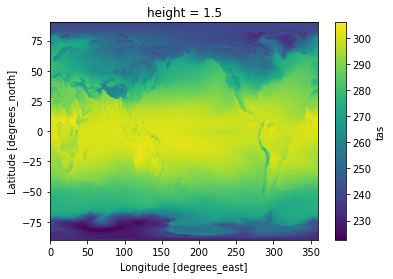

In [7]:
stored_data = xr.open_zarr(store, group=identifier)

time_mean = stored_data.mean(dim="time").compute()

time_mean.tas.plot()

# Remote Zarr store
This store is backed by an S3 Object Store. Here we'll use the `s3fs` package which provides python filesystem interface to S3.

In [8]:
def get_s3_store(root):
    import os
    import s3fs
    
    S3_HOST = os.environ["S3_HOST"]
    S3_PORT = os.environ["S3_PORT"]
    S3_REGION = os.environ["S3_REGION"]
    S3_ACCESS_KEY = os.environ["S3_ACCESS_KEY"]
    S3_SECRET_KEY = os.environ["S3_SECRET_KEY"]

    s3 = s3fs.S3FileSystem(
        key=S3_ACCESS_KEY,
        secret=S3_SECRET_KEY,
        use_ssl=False,
        client_kwargs = {
            "region_name": S3_REGION,
            "endpoint_url": f"http://{S3_HOST}:{S3_PORT}",
        },
        config_kwargs = {
            "signature_version": "s3",
        }
    )

    return s3, s3fs.S3Map(root="zarr-test", s3=s3, check=False)

In [9]:
s3, s3_store = get_s3_store("zarr-test")

subset.to_zarr(s3_store, group=identifier, consolidated=True)

Again we can view how zarr stores the dataset.

In [10]:
s3.ls(f"zarr-test/{identifier}")

['zarr-test/tas_3hr_HadGEM3-GC31-MM_historical_r1i1p1f3_gn_IUImKOcm/.zattrs',
 'zarr-test/tas_3hr_HadGEM3-GC31-MM_historical_r1i1p1f3_gn_IUImKOcm/.zgroup',
 'zarr-test/tas_3hr_HadGEM3-GC31-MM_historical_r1i1p1f3_gn_IUImKOcm/height',
 'zarr-test/tas_3hr_HadGEM3-GC31-MM_historical_r1i1p1f3_gn_IUImKOcm/lat',
 'zarr-test/tas_3hr_HadGEM3-GC31-MM_historical_r1i1p1f3_gn_IUImKOcm/lat_bnds',
 'zarr-test/tas_3hr_HadGEM3-GC31-MM_historical_r1i1p1f3_gn_IUImKOcm/lon',
 'zarr-test/tas_3hr_HadGEM3-GC31-MM_historical_r1i1p1f3_gn_IUImKOcm/lon_bnds',
 'zarr-test/tas_3hr_HadGEM3-GC31-MM_historical_r1i1p1f3_gn_IUImKOcm/tas',
 'zarr-test/tas_3hr_HadGEM3-GC31-MM_historical_r1i1p1f3_gn_IUImKOcm/time']

We can then load the dataset and perform the mean over the time axis.

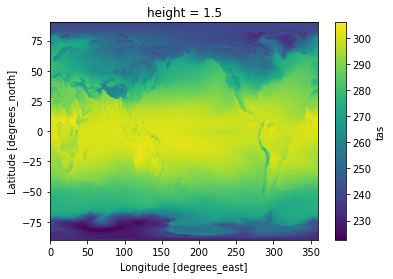

In [11]:
stored_data = xr.open_zarr(s3_store, group=identifier)

time_mean = stored_data.mean(dim="time").compute()

time_mean.tas.plot()

Finallay we can clean up the stored data.

In [12]:
s3.rm(f"zarr-test/{identifier}", True)